In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# price = '/content/drive/MyDrive/retail_price.csv'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pickle
import numpy as np
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

In [4]:
#price_data = pd.read_csv(price)
price_data = pd.read_csv('retail_price.csv')

In [5]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

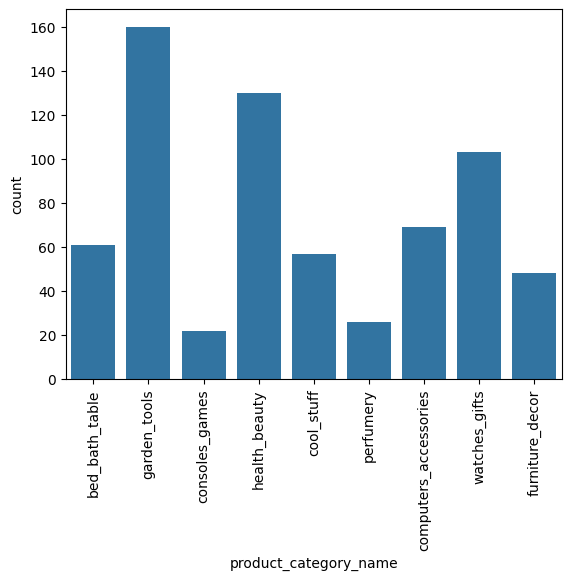

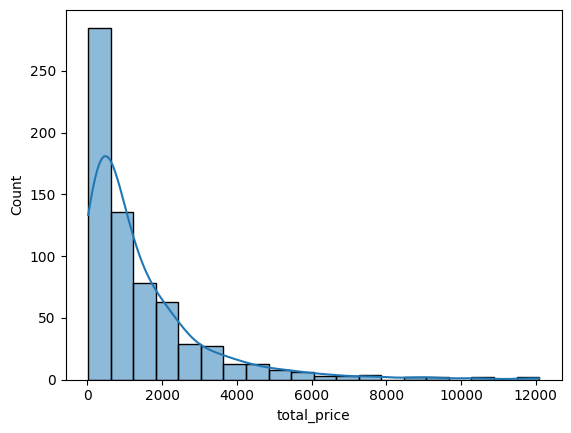

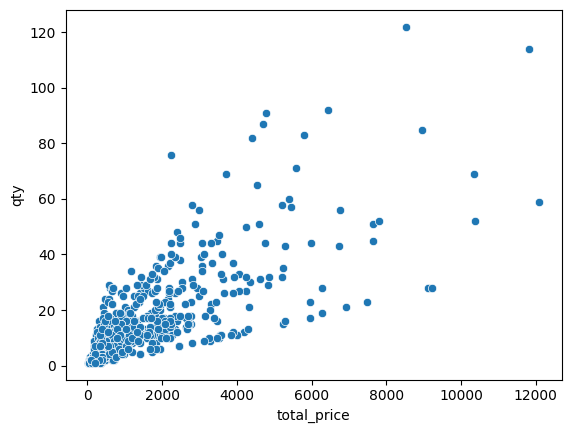

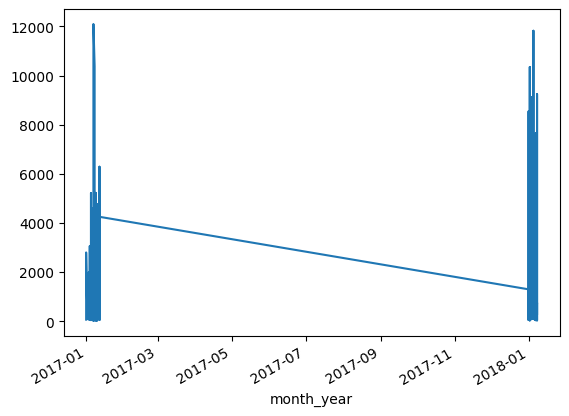

In [6]:
sns.countplot(x='product_category_name', data=price_data)
plt.xticks(rotation=90)
plt.show()

sns.histplot(price_data['total_price'], bins=20, kde=True)
plt.show()

# Bivariate Analysis
sns.scatterplot(x='total_price', y='qty', data=price_data)
plt.show()

# Time Series Analysis
price_data['month_year'] = pd.to_datetime(price_data['month_year'])
price_data.set_index('month_year')['total_price'].plot()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_7980\3993096314.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = price_data.corr()


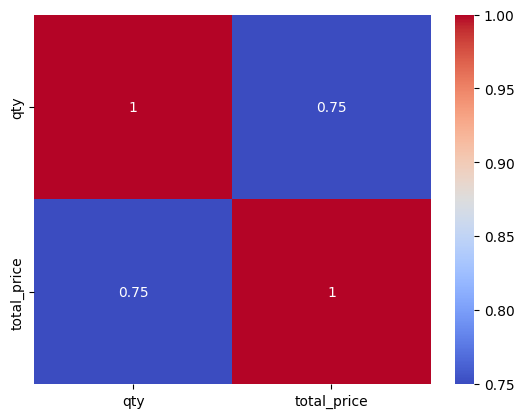

In [7]:
corr_matrix = price_data.corr()
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.show()

threshold = 0.5  # For example, you can change this threshold as needed

# Filter the correlation matrix to show only correlations above the threshold
price_corr = corr_matrix['total_price']  # Selecting correlations with respect to 'total_price'
high_corr_features = price_corr[price_corr.abs() > threshold].index

# Plot the filtered correlation matrix
sns.heatmap(corr_matrix.loc[high_corr_features, high_corr_features], annot=True, cmap='coolwarm')
plt.show()

In [8]:
price_data['year'].value_counts()

2018    355
2017    321
Name: year, dtype: int64

In [9]:
price_data.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price'],
      dtype='object')

In [10]:

import statsmodels.api as sm

def fit_models_for_all_categories(data):
    unique_categories = data['product_category_name'].unique()
    models = {}

    for category in unique_categories:
        category_data = data[data['product_category_name'] == category]
        exog = sm.add_constant(category_data[['unit_price']])
        model = sm.OLS(category_data['qty'], exog).fit()
        models[category] = model

    return models

# Example usage
category_models = fit_models_for_all_categories(price_data)

In [15]:
category_models.keys()

dict_keys(['bed_bath_table', 'garden_tools', 'consoles_games', 'health_beauty', 'cool_stuff', 'perfumery', 'computers_accessories', 'watches_gifts', 'furniture_decor'])

In [12]:
def store_models(models):
    for category, model in models.items():
        filename = f"{category}_model.pkl"
        with open(filename, 'wb') as file:
            pickle.dump(model, file)

# Store the models
store_models(category_models)

In [13]:
def find_optimal_price(data, models):
    start_price = data['unit_price'].min()
    end_price = data['unit_price'].max() * 1.1
    test_prices = np.arange(start_price, end_price, 1)

    results = []

    for category, model in models.items():
        test_df = pd.DataFrame({'PRICE': test_prices, 'QUANTITY': np.nan})
        test_df['QUANTITY'] = model.predict(sm.add_constant(test_df['PRICE']))
        optimal_price_index = test_df['QUANTITY'].idxmax()
        optimal_price_row = test_df.loc[optimal_price_index]
        results.append({'category': category,
                        'optimal_price': optimal_price_row['PRICE'],
                        'optimal_quantity': optimal_price_row['QUANTITY']})

    return results

# Example usage
optimal_prices = find_optimal_price(price_data, category_models)
for result in optimal_prices:
    print(f"Product Category: {result['category']}, Optimal Price: {result['optimal_price']}, Optimal Quantity: {result['optimal_quantity']}")

Product Category: bed_bath_table, Optimal Price: 399.9, Optimal Quantity: 59.31317738876709
Product Category: garden_tools, Optimal Price: 19.9, Optimal Quantity: 22.89285384041879
Product Category: consoles_games, Optimal Price: 19.9, Optimal Quantity: 16.153443374452806
Product Category: health_beauty, Optimal Price: 19.9, Optimal Quantity: 15.910845958465522
Product Category: cool_stuff, Optimal Price: 19.9, Optimal Quantity: 12.7649407069081
Product Category: perfumery, Optimal Price: 19.9, Optimal Quantity: 12.57559203798085
Product Category: computers_accessories, Optimal Price: 399.9, Optimal Quantity: 28.131269017917205
Product Category: watches_gifts, Optimal Price: 19.9, Optimal Quantity: 21.827999358565915
Product Category: furniture_decor, Optimal Price: 399.9, Optimal Quantity: 51.67571700451845
